In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
# from skimage import io
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow_io as tfio

import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
PROJECT_PATH = os.getcwd()

os.chdir('data/Healthcare AI Datasets/Brain_MRI')
os.listdir()

['data.csv',
 'data_mask.csv',
 'resnet-50-MRI.json',
 'ResUNet-MRI.json',
 'TCGA_CS_4941_19960909',
 'TCGA_CS_4942_19970222',
 'TCGA_CS_4943_20000902',
 'TCGA_CS_4944_20010208',
 'TCGA_CS_5393_19990606',
 'TCGA_CS_5395_19981004',
 'TCGA_CS_5396_20010302',
 'TCGA_CS_5397_20010315',
 'TCGA_CS_6186_20000601',
 'TCGA_CS_6188_20010812',
 'TCGA_CS_6290_20000917',
 'TCGA_CS_6665_20010817',
 'TCGA_CS_6666_20011109',
 'TCGA_CS_6667_20011105',
 'TCGA_CS_6668_20011025',
 'TCGA_CS_6669_20020102',
 'TCGA_DU_5849_19950405',
 'TCGA_DU_5851_19950428',
 'TCGA_DU_5852_19950709',
 'TCGA_DU_5853_19950823',
 'TCGA_DU_5854_19951104',
 'TCGA_DU_5855_19951217',
 'TCGA_DU_5871_19941206',
 'TCGA_DU_5872_19950223',
 'TCGA_DU_5874_19950510',
 'TCGA_DU_6399_19830416',
 'TCGA_DU_6400_19830518',
 'TCGA_DU_6401_19831001',
 'TCGA_DU_6404_19850629',
 'TCGA_DU_6405_19851005',
 'TCGA_DU_6407_19860514',
 'TCGA_DU_6408_19860521',
 'TCGA_DU_7008_19830723',
 'TCGA_DU_7010_19860307',
 'TCGA_DU_7013_19860523',
 'TCGA_DU_7014_

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    if history.history.get('val_loss'):
        plt.plot(history.history['val_loss'], label='val_loss', alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
data = pd.read_csv('data_mask.csv')

In [5]:
data

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
...,...,...,...,...
3924,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,0
3925,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,0
3926,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,0
3927,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,0


In [6]:
neg, pos = np.bincount(data['mask'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 3929
    Positive: 1373 (34.95% of total)



In [7]:
def separate_on_directory(data, dir_name: str):
  os.chdir(PROJECT_PATH)
  os.chdir('data/')

  if dir_name not in os.listdir():
    import shutil

    os.mkdir(dir_name)
    os.mkdir(dir_name+'/0')
    os.mkdir(dir_name+'/1')

    for i in data.values:
      src = 'Healthcare AI Datasets/Brain_MRI/'+i[1]


      if i[3] == 0:
         dest = dir_name+'/0'
         shutil.copy(src, dest)
      else:
         dest = dir_name+'/1'
         shutil.copy(src, dest)

In [8]:
separate_on_directory(data, 'tumors_unbalanced')

In [9]:
data_dir = pathlib.Path('./tumors_unbalanced/')
batch_size = 64
img_height = 256
img_width = 256

In [10]:
image_count = len(list(data_dir.glob('*/*.tif')))
print(image_count)

3929


In [11]:
list_ds = tf.data.Dataset.list_files(f'{data_dir}/*/*', shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [12]:
for f in list_ds.take(5):
  print(f.numpy())

b'tumors_unbalanced\\0\\TCGA_DU_7010_19860307_2.tif'
b'tumors_unbalanced\\0\\TCGA_HT_7605_19950916_12.tif'
b'tumors_unbalanced\\0\\TCGA_HT_7877_19980917_7.tif'
b'tumors_unbalanced\\0\\TCGA_DU_7010_19860307_13.tif'
b'tumors_unbalanced\\0\\TCGA_DU_8167_19970402_31.tif'


In [13]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['0' '1']


In [14]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

3144
785


In [15]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [16]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tfio.experimental.image.decode_tiff(img)
  # Resize the image to the desired size
  # return tf.image.resize(img, [img_height, img_width])
  return img

In [17]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 4)
Label:  1


In [20]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

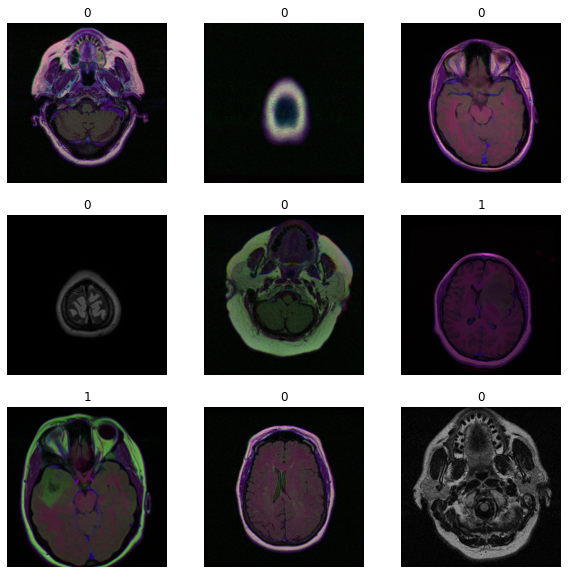

In [21]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [23]:
num_classes = len(class_names)
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 4)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    # layers.Dense(num_classes, bias_initializer=output_bias)

    return model

In [24]:
initial_bias = np.log([pos/neg])

model = make_model(output_bias=initial_bias)

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [27]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.77
Weight for class 1: 1.43


In [28]:
epochs=30
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(patience=2)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping_cb, reduce_lr_cb],
  class_weight=class_weight
)

Epoch 1/30
50/50 [==============================] - 114s 2s/step - loss: 0.6796 - accuracy: 0.6762 - val_loss: 0.5558 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 110s 2s/step - loss: 0.4965 - accuracy: 0.7548 - val_loss: 0.5742 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 102s 2s/step - loss: 0.4325 - accuracy: 0.7834 - val_loss: 0.3837 - val_accuracy: 0.8127 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 102s 2s/step - loss: 0.4066 - accuracy: 0.8031 - val_loss: 0.4369 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 109s 2s/step - loss: 0.3463 - accuracy: 0.8362 - val_loss: 0.3696 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 111s 2s/step - loss: 0.2996 - accuracy: 0.8581 - val_loss: 0.4869 - val_accuracy: 0.7707 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 103s 2s/step - loss: 0.2

KeyboardInterrupt: 

In [ ]:
pred = model.evaluate(val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

def model300():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.Dense(1000, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Dense(250, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
    return model


def nn():
    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(patience=5)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)

    model = model300()

    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=val_ds, epochs=200, validation_split=0.2,
                          callbacks=[reduce_lr_cb, early_stopping_cb])

    val_loss, val_acc = model.evaluate(train_ds)
    plot_loss(history)
    print('Validation loss: ', val_loss)
    print('Accuracy: ', round(val_acc, 2))


nn()

In [ ]:
tf.math.confusion_matrix(val_ds, pred, dtype=tf.uint8)

In [ ]:
# X_train.from sklearn.metrics import ConfusionMatrixDisplay
pred=model.predict(val_ds).round(0).ravel().astype('int')

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#
# model = ResNet50(input_shape=(256,256,3),include_top=False)
#
# model.compile(optimizer=tf.optimizers.Adam(),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
#
# history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)
#
# val_loss, val_acc = model.evaluate(X_test, y_test)